## Exploratory Data Analysis: IMDb Dataset

In this notebeook we will explore IMDb's dataset which is available online and **refreshed daily**. 

https://www.imdb.com/interfaces/

Seven gzipped file (tab separated values) can be downloaded from the website. Files are:

* title.akas.tsv.gz
* title.basics.tsv.gz
* title.crew.tsv.gz
* title.episode.tsv.gz
* title.principals.tsv.gz
* title.ratings.tsv.gz
* name.basics.tsv.gz

We will go through each of them one by one except "title.episode.tsv.gz" as we are only interested in movies in the notebook, not TV series.

Let's start with the necessary imports of the Python libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.style.use("seaborn-pastel")

Loading huge tables from IMDb dataset into our notebook takes a while; hence, we will do it once and save them in .sav format which is allowed by pickle library of Python, this will speed up data loading processes

In [2]:
import pickle
# import glob

# save all tables one by one into separate sav files
# tsv_files = glob.glob("*.tsv")

# for file in tsv_files:
#     print(file)
#     pickle.dump(pd.read_table(file,sep="\t",low_memory=False, na_values=["\\N","nan"]),
#                 open(file[:-4]+".sav","wb")) 

Let's examine tables one by one. From time to time we will join tables to do extra analysis in the notebook

### Ratings Table

title.ratings.tsv.gz – Contains the IMDb rating and votes information for titles
* **tconst** (string) - alphanumeric unique identifier of the title
* **averageRating** – weighted average of all the individual user ratings
* **numVotes** - number of votes the title has received

In [3]:
df_ratings = pickle.load(open("title.ratings.sav","rb"))
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1592
1,tt0000002,6.1,194
2,tt0000003,6.5,1267
3,tt0000004,6.2,120
4,tt0000005,6.1,2028


The **ratings** table contains over 1 million movie rating entries

In [4]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020911 entries, 0 to 1020910
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1020911 non-null  object 
 1   averageRating  1020911 non-null  float64
 2   numVotes       1020911 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 23.4+ MB


Average rating is 6.89 (mean) which is different from the median value (7.1), we will examine this further. Average number of votes per film is close to a thousand (mean), this time median (20) is significantly different than the mean

In [5]:
 df_ratings.describe()

,averageRating,numVotes
count,1.020911e+06,1.020911e+06
mean,6.889070e+00,9.635539e+02
std,1.397489e+00,1.583783e+04
min,1.000000e+00,5.000000e+00
25%,6.100000e+00,9.000000e+00
50%,7.100000e+00,2.000000e+01
75%,7.900000e+00,7.800000e+01
max,1.000000e+01,2.208178e+06


Average rating distribution shows a classic **negative skewed** distribution where median is larger than mean. Vote count distribution is heavily clustered around small values (0-1000 votes). Therefore we need to do a bit extra to visualise this packed distribution

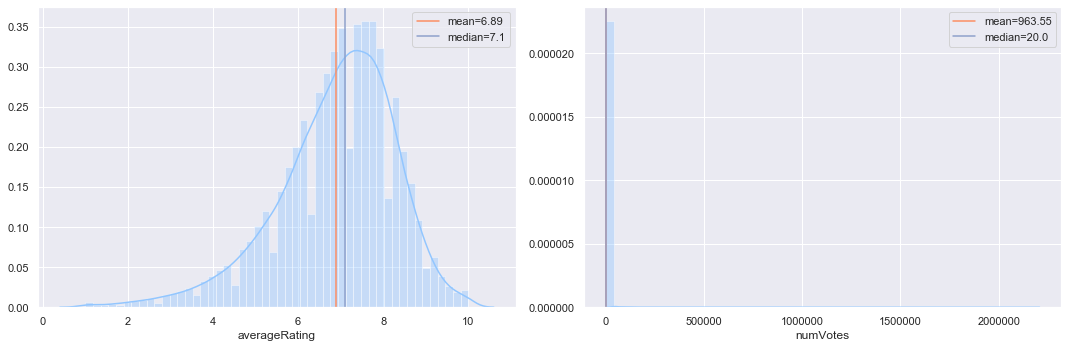

In [6]:
ratings = dict(mean=df_ratings.averageRating.mean(),
              median=df_ratings.averageRating.median())
votes = dict(mean=df_ratings.numVotes.mean(),
              median=df_ratings.numVotes.median())

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax1 = sns.distplot(df_ratings.averageRating,kde_kws=dict(bw=0.2))
ax1.axvline(x=ratings["mean"],c=sns.color_palette("Set2")[1],label=f"mean={ratings['mean'].round(2)}")
ax1.axvline(x=ratings["median"],c=sns.color_palette("Set2")[2],label=f"median={ratings['median'].round(2)}")
plt.legend()

plt.subplot(1,2,2)
ax2 = sns.distplot(df_ratings.numVotes,kde_kws=dict(bw=0.2))
ax2.axvline(x=votes["mean"],c=sns.color_palette("Set2")[1],label=f"mean={votes['mean'].round(2)}")
ax2.axvline(x=votes["median"],c=sns.color_palette("Set2")[2],label=f"median={votes['median'].round(2)}")
plt.legend()

plt.tight_layout()
plt.show()

Let's try to use pandas.qcut function, which discretizes the variable into equal-sized buckets based on rank or based on sample quantiles. Let's divide our data into 20 buckets and visualise:
* Over 140K samples (more than 10%) have only 5 votes counted
* The films having more than 1095 votes are represented with a single bar in the plot which counts around 50K (these are the significant/popular films we are mostly interested of)

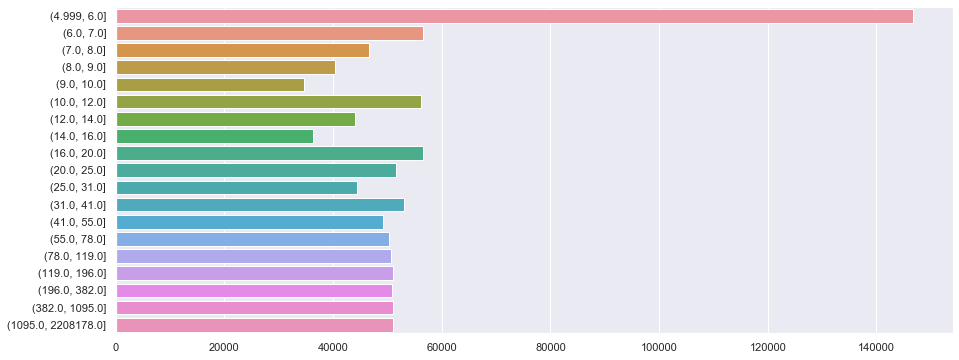

In [7]:
buckets = 20
plt.figure(figsize=(15,6))
bins = pd.qcut(df_ratings.numVotes,buckets,duplicates="drop").value_counts()
sns.barplot(x=bins.values,y=bins.index,orient="h")
plt.show(9)

Also we can consider plotting the distribution in logarithmic scale which reveals more. Since it is a count variable, it looks more like a Poisson distribution

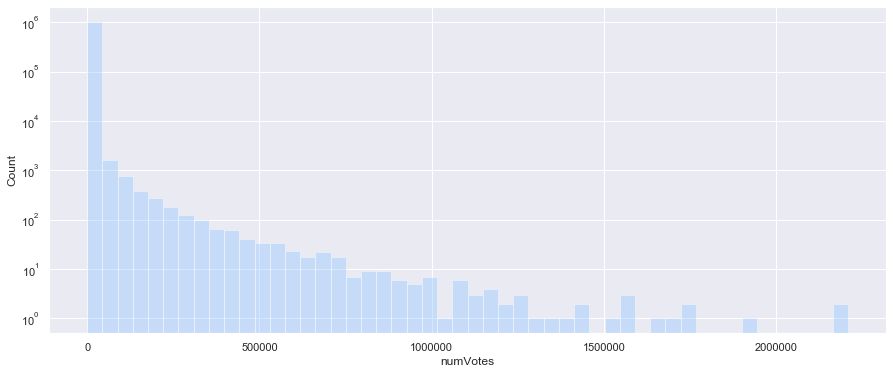

In [8]:
plt.figure(figsize=(15,6))
ax=sns.distplot(df_ratings.numVotes,kde=False)
ax.set_ylabel("Count")
ax.set_yscale("log")

### Title Basics Table

title.basics.tsv.gz - Contains the following information for titles:
* **tconst** (string) - alphanumeric unique identifier of the title
* **titleType** (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
* **primaryTitle** (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
* **originalTitle** (string) - original title, in the original language
* **isAdult** (boolean) - 0: non-adult title; 1: adult title
* **startYear** (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
* **endYear** (YYYY) – TV Series end year. ‘\N’ for all other title types
* **runtimeMinutes** – primary runtime of the title, in minutes
* **genres** (string array) – includes up to three genres associated with the title

In [9]:
df_title_basics = pickle.load(open("title.basics.sav","rb"))
df_title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4,NaN
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12,NaN
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1,"Comedy,Short"


Title basics table is way larger than the ratings table with over **6 million** entries each of which describe basic information about the video titles. I said video as it not only includes films, but also tv series, short videos (short films and music clips), even video games

In [10]:
df_title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682995 entries, 0 to 6682994
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   tconst          object 
 1   titleType       object 
 2   primaryTitle    object 
 3   originalTitle   object 
 4   isAdult         int64  
 5   startYear       float64
 6   endYear         float64
 7   runtimeMinutes  object 
 8   genres          object 
dtypes: float64(2), int64(1), object(6)
memory usage: 458.9+ MB


Let's explore columns one by one. Title type distribution is as follows:
* Majority of the titles are TV episodes (71%)
* Movies (including TV movies) only cover 10% of the dataset

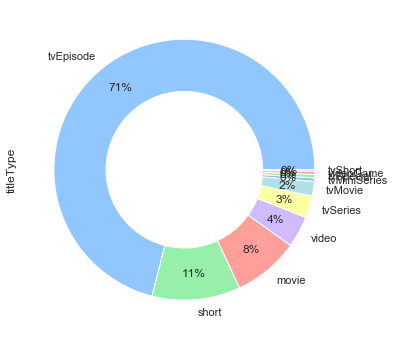

In [11]:
df_title_basics.titleType.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,
                                                 wedgeprops=dict(width=0.4))
plt.show()

Let's trim dataset as we are interested only on the movies. After trimming is done majority of the titles now are movies (82%) and the remaining 120K titles are TV movies

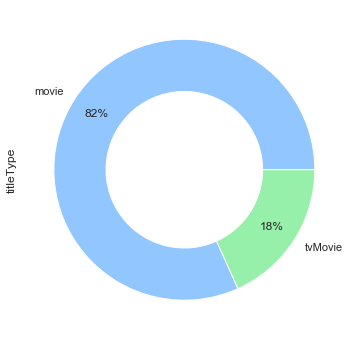

In [12]:
df_title_basics = df_title_basics[df_title_basics.isAdult == 0]
df_title_basics.drop(["isAdult","endYear"],axis=1,inplace=True)
df_title_basics = df_title_basics[(df_title_basics.titleType == "movie") | (df_title_basics.titleType == "tvMovie")]

df_title_basics.titleType.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,
                                                 wedgeprops=dict(width=0.4))
plt.show()

How about the distribution of **Genres**, the pie chart below doesn't look charming right? It is because movies have multiple genres, therefore what we see below is combination of genres each representing a slice in the pie

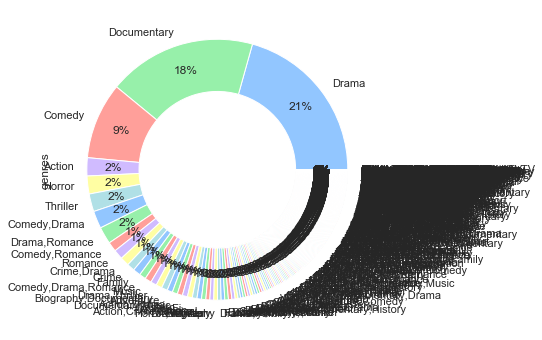

In [13]:
df_title_basics.genres.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,
                                              wedgeprops=dict(width=0.4))
plt.show()

To overcome this, we can use Scikit-Learn's **CountVectorizer** feature extraction technique to detect and count each unique genre (e.g. drama, comedy etc). We will create a new column for each unique Genre title and it will be True/False if a movie have that genre or not

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

temp = df_title_basics.genres.dropna()
vec = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
bag_of_genres = vec.transform(temp)
unique_genres =  vec.get_feature_names()
np.array(unique_genres)

array(['action', 'adult', 'adventure', 'animation', 'biography', 'comedy',
       'crime', 'documentary', 'drama', 'family', 'fantasy', 'film-noir',
       'game-show', 'history', 'horror', 'music', 'musical', 'mystery',
       'news', 'reality-tv', 'romance', 'sci-fi', 'sport', 'talk-show',
       'thriller', 'war', 'western'], dtype='<U11')

It did very well by finding unique genres and counting them. Note that, in the bar chart below, since a movie may have multiple genres at a time, their count will not be 100%

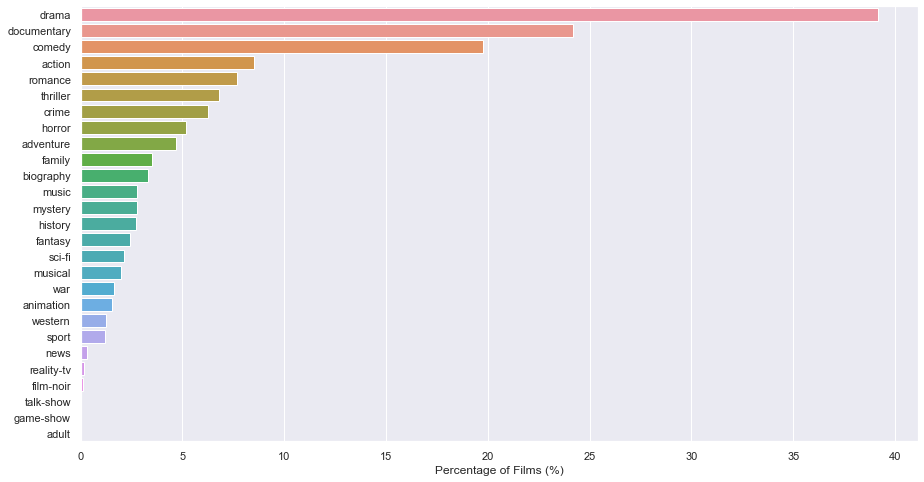

In [15]:
genres = pd.DataFrame(bag_of_genres.todense(),columns=unique_genres,index=temp.index)
sorted_genres_perc = 100*pd.Series(genres.sum()).sort_values(ascending=False)/genres.shape[0]

plt.figure(figsize=(15,8))
sns.barplot(x=sorted_genres_perc.values,y=sorted_genres_perc.index,orient="h")
plt.xlabel("Percentage of Films (%)")
plt.show()

How about the trend for the **number of voters per year** and **voter counts per year / per film**?

The graph below contains two subplots, the former gives the total number of films made each year, and the latter gives total number of voters for the films made at corresponding year which was peaked in **2013** (37 million vote count total for the films released in 2013) and follows a dramatic decline in count. This is where the things get interesting. Number of films made per year increases until **2017** but why people stop voting recent films? Is it because the quality of movies getting worse? Or is it the IMDb website loosing its popularity? However it is obvious that IMDb still dominates online film rating sector as their mind blowing monthly visitor number reaches to 250 millio.

[*read more: https://www.businesswire.com/news/home/20180222005150/en/IMDb-Launches-First-Ever-Skill-Amazon-Alexa*]

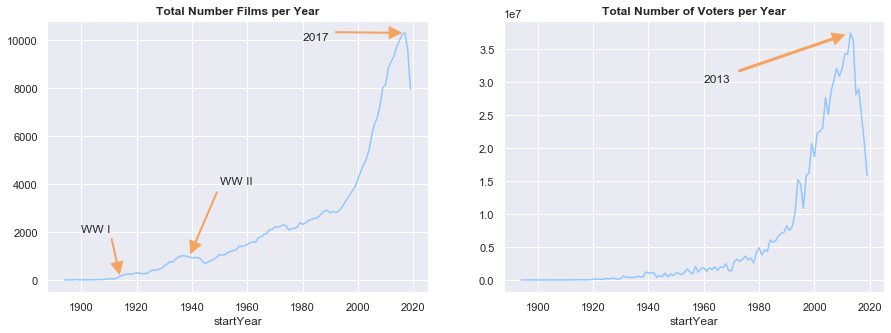

In [16]:
merged_temp = pd.merge(df_ratings,df_title_basics,on="tconst",how="left")
merged_temp = merged_temp[(merged_temp.startYear.notnull())&(merged_temp.startYear<2020)]
counts_yearly = merged_temp.groupby("startYear").agg({"averageRating":[np.median],
                                                     "numVotes":[np.sum,np.size,lambda x: np.sum(x)/np.size(x)]})

max_count_year = counts_yearly[("numVotes","sum")].idxmax().astype(int)
max_year = counts_yearly[("numVotes","size")].idxmax().astype(int)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax =counts_yearly[("numVotes","size")].plot()
ax.annotate(max_year,xy=(max_year,counts_yearly[("numVotes","size")].max()),
            xytext=(1980,10000), arrowprops=dict(color="sandybrown",shrink=0.05,width=1))
ax.annotate("WW I",xy=(1914,counts_yearly[("numVotes","size")].loc[1914]), xytext=(1900,2000), 
            arrowprops=dict(color="sandybrown",shrink=0.05,width=1))
ax.annotate("WW II",xy=(1939,counts_yearly[("numVotes","size")].loc[1939]), xytext=(1950,4000), 
            arrowprops=dict(color="sandybrown",shrink=0.05,width=1))
plt.title("Total Number Films per Year",fontweight="bold")

plt.subplot(1,2,2)
ax =counts_yearly[("numVotes","sum")].plot()
ax.annotate(max_count_year,xy=(max_count_year,counts_yearly[("numVotes","sum")].max()),
            xytext=(1960,3e7),arrowprops=dict(shrink=0.05,color="sandybrown",width=2))
plt.title("Total Number of Voters per Year",fontweight="bold")

plt.show()

This could be another research point, let's continue to find more interesting points in the data.

The graph below have two subplots again. The former gives average rating of films per year, whereas the latter displays the average voters per film again on a yearly basis. Since 1920s, average film ratings tend fluctuate but not showing a monotonic increase/decrease trend. 

The latter graph reaches the peak at **90s** and early 2000s and has been dropping dramatically since then. Recall that the total number of voters per year was peaked in 2013, not 90s. This means that **90s films got the attention from users the most**. This can be related to the dominance of the age group of the IMDb voters. Since we don't have that information, we can guess that the dominant age group must be in the range of 30 to 50. 90s films are their childhood or teenager times films which you get impressed the most of a film huh? There could be other factors like 90s films are better etc.

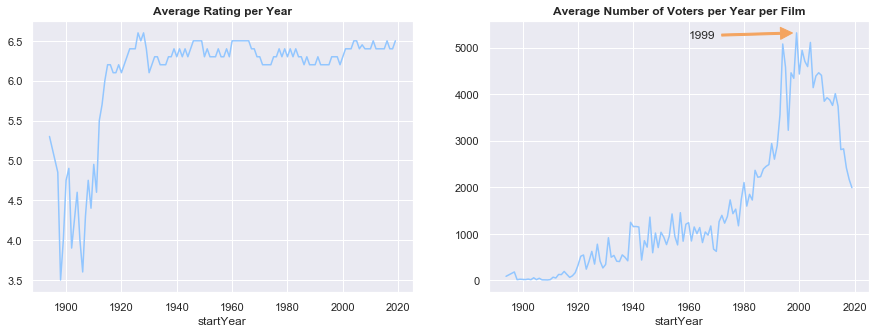

In [17]:
max_count_year_per_film = counts_yearly[("numVotes","<lambda_0>")].idxmax().astype(int)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax =counts_yearly[("averageRating","median")].plot()
plt.title("Average Rating per Year",fontweight="bold")

plt.subplot(1,2,2)
ax = counts_yearly[("numVotes","<lambda_0>")].plot()
ax.annotate(max_count_year_per_film,xy=(max_count_year_per_film,counts_yearly[("numVotes","<lambda_0>")].max()),
            xytext=(1960,5200),arrowprops=dict(shrink=0.05,color="sandybrown",width=2))
plt.title("Average Number of Voters per Year per Film",fontweight="bold")

plt.show()

Let's now visualise the distribution of film **runtimes** in minutes. The single bar below is an indication that there are a few **outlier films** which have a runtime over 50000 minutes

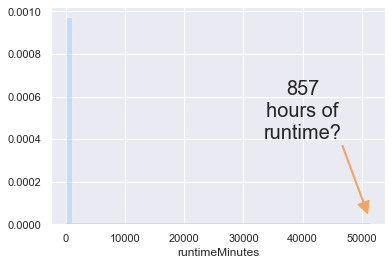

In [18]:
sns.distplot(df_title_basics.runtimeMinutes.dropna().astype(int),bins=50)
plt.gca().annotate("857\nhours of\nruntime?",xy=(51000,0.00005),xytext=(40000,0.0004),
                   fontsize=20, ha="center",
                   arrowprops=dict(color="sandybrown",width=1))
plt.show()

A 35 days (**857 hours**) long film? Let's find out which film it is

In [19]:
import warnings
warnings.filterwarnings("ignore")

use = df_title_basics[df_title_basics.runtimeMinutes.notnull()]
use["runtimeMinutes"] = use.runtimeMinutes.astype(int)
use[use.runtimeMinutes>50000]

,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
5905749,tt8273150,movie,Logistics,Logistics,2012.0,51420,NaN


It is **Logistics (2012)**, longest made documentary ever. A 72 minutes long edit can be seen in the following YouTube link:

https://www.youtube.com/watch?v=QYFG0xP12yE

Many may not consider it as a form of art, rather a camera placed on top of a container ship and kept shooting it 35 days. Similarly Beijing 2003 and Modern Times Forever are shoot with similar purposes

In [20]:
use.sort_values(by="runtimeMinutes",ascending=False).head()

,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
5905749,tt8273150,movie,Logistics,Logistics,2012.0,51420,NaN
3385893,tt2659636,movie,Modern Times Forever,Modern Times Forever,2011.0,14400,NaN
1452016,tt10844900,movie,Qw,Qw,2019.0,10062,Drama
3238084,tt2355497,movie,Beijing 2003,Beijing 2003,2004.0,9000,Documentary
4439888,tt5068890,movie,Hunger!,Hunger!,2015.0,6000,"Documentary,Drama"


In order to see a clear distribution of "films" we need to take these outliers off from the data and plot the rest. We will do that by focusing only the movies with **300 minutes** runtime or less:
* Now it looks like a normal distribution centered around 90 minutes

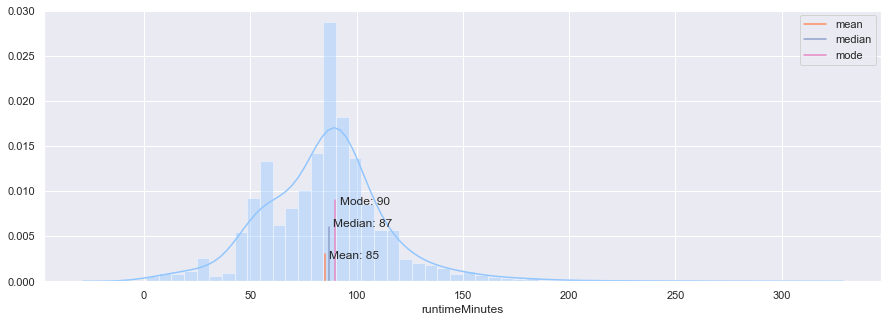

In [21]:
rt = use.runtimeMinutes[use.runtimeMinutes<300]
mean_rt,median_rt,mode_rt = rt.mean(),rt.median(),rt.mode()[0]

plt.figure(figsize=(15,5))
sns.distplot(rt,kde_kws=dict(bw=10))
plt.gca().axvline(mean_rt,label="mean",color=sns.color_palette("Set2")[1],ymax=0.1)
plt.gca().axvline(median_rt,label="median",color=sns.color_palette("Set2")[2],ymax=0.2)
plt.gca().axvline(mode_rt,label="mode",color=sns.color_palette("Set2")[3],ymax=0.3)
plt.text(mean_rt+2,0.0025,f"Mean: {int(mean_rt)}")
plt.text(median_rt+2,0.006,f"Median: {int(median_rt)}")
plt.text(mode_rt+2,0.0085,f"Mode: {int(mode_rt)}")
plt.legend()
plt.show()

Now list the **Top 20 movies with the highest voter count**, first we need to merge df_ratings and df_title_basics tables and sort the table according to the number of votes:
* Popular movies like Fight Club, The Matrix, Lord of the Rings trio are made the list as expected
* Except The Godfather, Top20 voted films are from 90s to the present

In [22]:
merged = pd.merge(df_ratings,df_title_basics,on="tconst",how="right").sort_values(by="numVotes",ascending=False)
merged[["numVotes","primaryTitle","startYear"]].iloc[:20,:]

,numVotes,primaryTitle,startYear
64793,2208178.0,The Shawshank Redemption,1994.0
147151,2187527.0,The Dark Knight,2008.0
181127,1936634.0,Inception,2010.0
75457,1762495.0,Fight Club,1999.0
64599,1734264.0,Pulp Fiction,1994.0
63883,1704149.0,Forrest Gump,1994.0
74296,1589019.0,The Matrix,1999.0
70671,1580024.0,The Lord of the Rings: The Fellowship of the Ring,2001.0
82507,1567931.0,The Lord of the Rings: The Return of the King,2003.0
36058,1520941.0,The Godfather,1972.0


Let's find out the **Top 20 highest rated films**, we will use the merged table again by just sorting it with averageRating. Like Top250 top rated films of IMDb website we will put a precondition to avoid listing "unknown" high rated films. Therefore we will only take into consideration of films which received ratings from at least **25000 users**:
* It is still not the same as Top250 of IMDb website since a Turkish film called "Hababam Sinifi" tops our list with 9.4 average rating
* This was because their Top250 list is ranked by a formula which includes the number of ratings each movie received from users, and value of ratings received from **regular users**
* Since we do not have regular users information, we cannot filter them

In [23]:
merged[merged.numVotes>25000].sort_values(by="averageRating",ascending=False).head(20)

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
104439,tt0252487,9.4,35180.0,movie,The Chaos Class,Hababam Sinifi,1975.0,87,"Comedy,Drama"
64793,tt0111161,9.3,2208178.0,movie,The Shawshank Redemption,The Shawshank Redemption,1994.0,142,NaN
220664,tt2592910,9.2,42686.0,movie,CM101MMXI Fundamentals,CM101MMXI Fundamentals,2013.0,139,NaN
36058,tt0068646,9.2,1520941.0,movie,The Godfather,The Godfather,1972.0,175,"Crime,Drama"
147151,tt0468569,9.0,2187527.0,movie,The Dark Knight,The Dark Knight,2008.0,152,"Action,Crime,Drama"
38154,tt0071562,9.0,1065519.0,movie,The Godfather: Part II,The Godfather: Part II,1974.0,202,NaN
259472,tt5813916,8.9,102699.0,movie,The Mountain II,Dag II,2016.0,135,"Action,Drama,War"
22615,tt0050083,8.9,644925.0,movie,12 Angry Men,12 Angry Men,1957.0,96,Drama
64599,tt0110912,8.9,1734264.0,movie,Pulp Fiction,Pulp Fiction,1994.0,154,NaN
62870,tt0108052,8.9,1151647.0,movie,Schindler's List,Schindler's List,1993.0,195,"Biography,Drama,History"


Let's now list the Worst rated 20 films:
* Again three Turkish films tops the list, Turkish users have been very active huh?
* Some of the read bad films are **Disaster Movie**, **Supebabies**, **Epic Movie**, **Meet the Spartans** etc.

In [24]:
merged[merged.numVotes>25000].sort_values(by="averageRating",ascending=True).head(20)

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
271753,tt7221896,1.0,37442.0,movie,Cumali Ceber: Allah Seni Alsin,Cumali Ceber: Allah Seni Alsin,2017.0,100,NaN
245174,tt4458206,1.3,26953.0,movie,Code Name: K.O.Z.,Kod Adi K.O.Z.,2015.0,114,NaN
261313,tt5988370,1.4,72012.0,movie,Reis,Reis,2017.0,108,NaN
194376,tt1702443,1.6,75016.0,movie,Justin Bieber: Never Say Never,Justin Bieber: Never Say Never,2011.0,105,"Documentary,Music"
30363,tt0060666,1.9,34119.0,movie,Manos: The Hands of Fate,Manos: The Hands of Fate,1966.0,70,NaN
173826,tt1213644,1.9,85110.0,movie,Disaster Movie,Disaster Movie,2008.0,87,NaN
153899,tt0804492,1.9,35761.0,movie,The Hottie & the Nottie,The Hottie & the Nottie,2008.0,91,"Comedy,Romance"
109293,tt0270846,1.9,29348.0,movie,Superbabies: Baby Geniuses 2,Superbabies: Baby Geniuses 2,2004.0,88,"Comedy,Family,Sci-Fi"
273262,tt7431594,2.0,30691.0,movie,Race 3,Race 3,2018.0,160,"Action,Thriller"
120681,tt0317676,2.0,35314.0,movie,House of the Dead,House of the Dead,2003.0,90,NaN


Let's visualise average ratings (median) of film genres. We will use the same counter which we used above:
* Highest rating average is taken by documentaries and news categories (both political)
* horror and sci-fi are in the bottom of the list (could be due to too many nonsense examples in both)

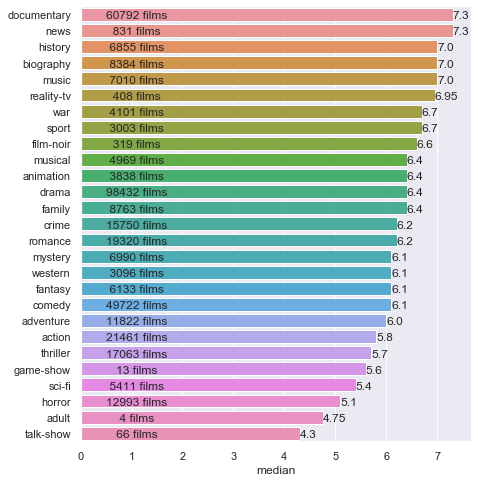

In [25]:
merged_temp = merged[merged.genres.notnull()]
vec = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(merged_temp.genres)
bag_of_genres = pd.DataFrame(vec.transform(merged_temp.genres).todense(),
                             columns=vec.get_feature_names(),index=merged_temp.index)
merged_temp = pd.concat([merged_temp,bag_of_genres],axis=1)

rating_counts_means = pd.DataFrame([[merged_temp.averageRating[merged_temp[i]==1].median(),merged_temp[i].sum()] 
 for i in vec.get_feature_names()],columns=["median","count"],index=vec.get_feature_names()).sort_values("median",ascending=False)

plt.figure(figsize=(7,8))
sns.barplot(y=rating_counts_means.index,x=rating_counts_means["median"],orient="h")
for i,counts in enumerate(rating_counts_means["count"]):
    plt.text(0.5,i+0.25,f"{counts:>5} films")
    plt.text(rating_counts_means["median"][i],i+0.25,rating_counts_means["median"][i])
plt.show()

Do users tend to rate higher on movies with longer runtime? Let's find out:
* Runtimes of movies are grouped using pandas' qcut (bins are chosen automatically by qcut to distribute equal number of samples for each group)
* Outlier films are not visualised in the boxplot
* Boxplot medains (vertical lines in each bin) show that the **average rating tend to increase when movie runtime increases**
* The reason that films with 84m and less runtime being exception could be that this group contains alot of **animation films** which have high rates

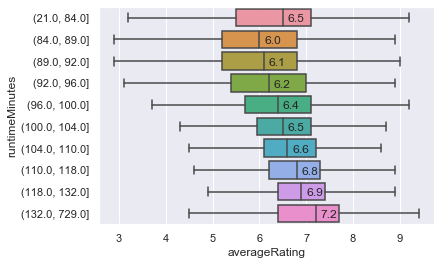

In [26]:
use = merged_temp[merged_temp.numVotes>1000]
use["runtimeMinutes"] = pd.to_numeric(use.runtimeMinutes)
[groups,edges] = pd.qcut(use.runtimeMinutes,10,precision=0,retbins=True)
ratings_avg = use.groupby(groups).agg({"averageRating":np.median})
sns.boxplot(y=groups,x="averageRating",data=use,orient="h",showfliers=False)
for i,rate in enumerate(ratings_avg["averageRating"]):
    plt.text(rate+0.1,i+0.2,rate)
plt.show()

### Name Basics Table

name.basics.tsv.gz – Contains the following information for names:
* **nconst** (string) - alphanumeric unique identifier of the name/person
* **primaryName** (string)– name by which the person is most often credited
* **birthYear** – in YYYY format
* **deathYear** – in YYYY format if applicable, else '\N'
* **primaryProfession** (array of strings)– the top-3 professions of the person
* **knownForTitles** (array of tconsts) – titles the person is known for

In [27]:
df_name_basics = pickle.load(open("name.basics.sav","rb"))
df_name_basics.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0053137,tt0050419,tt0072308,tt0043044"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0071877,tt0038355,tt0037382,tt0117057"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,producer","tt0049189,tt0057345,tt0054452,tt0059956"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0072562,tt0077975,tt0078723,tt0080455"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0083922,tt0069467,tt0050986,tt0050976"


The table has almost **10 million names** coming from different professions such as actors, actresses, directors, writers etc. It contains their birth and death year info as well as their most known work of art

In [28]:
df_name_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9991422 entries, 0 to 9991421
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   nconst             object 
 1   primaryName        object 
 2   birthYear          float64
 3   deathYear          float64
 4   primaryProfession  object 
 5   knownForTitles     object 
dtypes: float64(2), object(4)
memory usage: 457.4+ MB


Birth year distribution of the persons in the dataset is displayed below. The dataset contains even ancient writers from year 4 A.D.

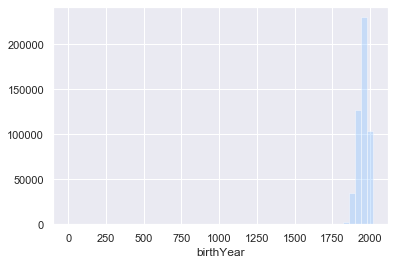

In [29]:
sns.distplot(df_name_basics.birthYear.dropna(),kde=False)
plt.show()

The **Top 10 ancient persons** in the dataset:
* Lucio Anneo Seneca was born in 4AD being the most ancient person in the dataset
* Some entries have wrong birth/death year info such as negative lifespans or extreme lifespans (e.g. George Sanger birth 23AD, death 1911) 

In [30]:
df_name_basics.sort_values("birthYear").head(10)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
740892,nm0784172,Lucio Anneo Seneca,4.0,65.0,writer,"tt0049203,tt0970456,tt0972562,tt0218822"
6533796,nm5796092,Kazuki Akiba,6.0,NaN,"producer,director,writer","tt2992302,tt5206688,tt4472058,tt8165436"
8200802,nm7876117,Guillaume Pelletier,6.0,NaN,"actor,director,assistant_director","tt6032352,tt5859024,tt6197424,tt5062900"
5373745,nm4511421,Megan Liz Smith,12.0,NaN,actress,"tt1966378,tt3416744"
8973562,nm8810146,Paul Walsh,21.0,NaN,actor,"tt0314567,tt0098878,tt0093223"
5928378,nm5121666,George Sanger,23.0,1911.0,NaN,tt2228122
408292,nm0430769,Flavius Josephus,37.0,95.0,"writer,miscellaneous","tt0325495,tt0049833,tt0009573,tt0273236"
2523346,nm1306202,Plutarch,46.0,122.0,writer,"tt0092322,tt0056937,tt0272979,tt0472473"
488079,nm0515385,Titus Livius,59.0,17.0,writer,tt0003740
2523822,nm1306711,Suetonius,69.0,140.0,writer,"tt0056937,tt0237666,tt3395994,tt0092322"


Distribution of lifespans of persons in the dataset:
* Shows a negative skew where mode>median>mean which is expected for distributions showing age at death

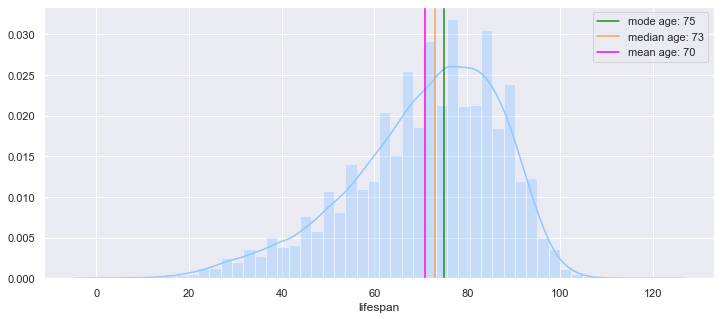

In [31]:
use = df_name_basics[["birthYear","deathYear","primaryName"]].dropna()
use["lifespan"] = use.deathYear - use.birthYear
use["lifespan"][(use.lifespan>200)|(use.lifespan<0)]=use.lifespan.median()

plt.figure(figsize=(12,5))
ax = sns.distplot(use.lifespan)
ax.axvline(use.lifespan.mode()[0],label=f"mode age: {int(use.lifespan.mode()[0])}",color="forestgreen")
ax.axvline(use.lifespan.median(),label=f"median age: {int(use.lifespan.median())}",color="sandybrown")
ax.axvline(use.lifespan.mean(),label=f"mean age: {int(use.lifespan.mean())}",color="fuchsia")
plt.legend()
plt.show()

Let's find out **Top 10 persons who have the longest lifespan** in the dataset:
* Jeanne Louise Calment, died when she was 122 years of age, had longest confirmed human life span in history (https://en.wikipedia.org/wiki/Jeanne_Calment)
* Even though she did not take part in any movie whatsoever, she appeared in a documentary about her, which is why she is in our dataset

In [32]:
use.sort_values("lifespan",ascending=False).head(10)

,birthYear,deathYear,primaryName,lifespan
124609,1875.0,1997.0,Jeanne Louise Calment,122.0
231063,1849.0,1970.0,Tatzumbia Dupea,121.0
5197956,1772.0,1890.0,Fakir Lalon Shah,118.0
3937737,1898.0,2015.0,Misao Ogawa,117.0
3073279,1893.0,2009.0,Maria De Jesus,116.0
262162,1896.0,2012.0,Gustave Field,116.0
4403400,1894.0,2009.0,Gertrude Baines,115.0
7528434,1900.0,2015.0,Ethel Lang,115.0
4038442,1893.0,2008.0,Edna Parker,115.0
3760574,1895.0,2009.0,Tomoji Tanabe,114.0


### Title Crew Table

title.crew.tsv.gz – Contains the director and writer information for all the titles in IMDb. Fields include:
* **tconst** (string) - alphanumeric unique identifier of the title
* **directors** (array of nconsts) - director(s) of the given title
* **writers** (array of nconsts) – writer(s) of the given title

In [33]:
df_title_crew = pickle.load(open("title.crew.sav","rb"))
df_title_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


The table consist of **6.6 million** entries

In [34]:
df_title_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682995 entries, 0 to 6682994
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   tconst     object
 1   directors  object
 2   writers    object
dtypes: object(3)
memory usage: 153.0+ MB


Some films have large amount of writers and directors. To analyse it, we need to combine three tables (title ratings, title crew, title basics)

In [35]:
merged = pd.merge(pd.merge(df_title_basics,df_title_crew,on="tconst",how="left"),df_ratings,on="tconst",how="left")
merged.head(10)

,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,directors,writers,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,1894.0,45,Romance,nm0085156,nm0085156,5.3,88.0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1897.0,20,"Documentary,News,Sport",nm0714557,NaN,5.2,333.0
2,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,1900.0,NaN,NaN,"nm0095714,nm0675140",NaN,6.1,40.0
3,tt0000502,movie,Bohemios,Bohemios,1905.0,100,NaN,nm0063413,"nm0063413,nm0657268,nm0675388",4.4,5.0
4,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,1906.0,70,NaN,nm0846879,nm0846879,6.1,561.0
5,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,1907.0,NaN,Drama,nm0533958,"nm0092809,nm0533958",4.5,15.0
6,tt0000630,movie,Hamlet,Amleto,1908.0,NaN,NaN,nm0143333,nm0000636,3.4,11.0
7,tt0000675,movie,Don Quijote,Don Quijote,1908.0,NaN,Drama,nm0194088,nm0148859,4.2,9.0
8,tt0000676,movie,Don Álvaro o la fuerza del sino,Don Álvaro o la fuerza del sino,1908.0,NaN,Drama,nm0194088,nm0729044,3.6,8.0
9,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,1908.0,120,"Adventure,Fantasy","nm0877783,nm0091767","nm0000875,nm0877783",4.8,34.0


We will be able to do analysis on 591K films for their directors and 492K films for their writers as the merged table have those numbers of non-null rows

In [36]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 658608 entries, 0 to 658607
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          658608 non-null  object 
 1   titleType       658608 non-null  object 
 2   primaryTitle    658608 non-null  object 
 3   originalTitle   658608 non-null  object 
 4   startYear       592644 non-null  float64
 5   runtimeMinutes  419983 non-null  object 
 6   genres          251408 non-null  object 
 7   directors       591101 non-null  object 
 8   writers         492270 non-null  object 
 9   averageRating   285470 non-null  float64
 10  numVotes        285470 non-null  float64
dtypes: float64(3), object(8)
memory usage: 60.3+ MB


* The pie chart below says that it is not as common to have multiple directors (8%) for a film as compared to multiple writers (44%)
* Vast majority of films (92%) have a single director, almost 1/3 of films have a writer duo

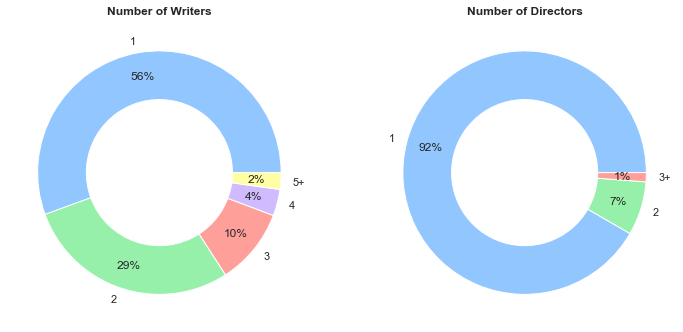

In [37]:
writer_counts = merged.writers.dropna().apply(lambda x: len(x.split(",")))
writer_counts[writer_counts>4] = "5+"
director_counts = merged.directors.dropna().apply(lambda x: len(x.split(",")))
director_counts[director_counts>2] = "3+"

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
writer_counts.value_counts().plot.pie(autopct="%.0f%%",pctdistance=0.8,
                                     wedgeprops=dict(width=0.4))
plt.title("Number of Writers",fontweight="bold")
plt.ylabel(None)

plt.subplot(1,2,2)
director_counts.value_counts().plot.pie(autopct="%.0f%%",pctdistance=0.8,
                                     wedgeprops=dict(width=0.4))
plt.title("Number of Directors",fontweight="bold")
plt.ylabel(None)

plt.show()

Some extreme number of writers for a movie:
* Ted Bundy Had a Son have **62 writers**
* 50 kisses producers promotes the film with the following motto: "50 writers. 50 filmmakers. One picture."

In [38]:
writer_counts = merged.writers.dropna().apply(lambda x: len(x.split(",")))
temp = merged[["startYear","primaryTitle","writers"]].loc[writer_counts.nlargest(5).index]
temp["Writer Count"] = writer_counts.nlargest(5)
temp

,startYear,primaryTitle,writers,Writer Count
480152,NaN,Ted Bundy Had a Son,"nm8657020,nm5755088,nm8657022,nm8657023,nm8468...",62
411065,2014.0,50 Kisses,"nm4270156,nm4380489,nm5443971,nm5443955,nm2478...",52
446793,2011.0,Our Footloose Remake,"nm0685673,nm3889830,nm3396174,nm2936815,nm2466...",47
485632,2016.0,World of Death,"nm6031788,nm3421748,nm3792014,nm4900080,nm1562...",47
267948,2019.0,Innerscape,"nm2168869,nm11208014,nm11208008,nm8776436,nm11...",43


Also top films with high number of directors:
* **Ted Bundy Had a Son** again becomes the top film now with staggering **88 directors**

In [39]:
director_counts = merged.directors.dropna().apply(lambda x: len(x.split(",")))
temp = merged[["startYear","primaryTitle","directors"]].loc[director_counts.nlargest(5).index]
temp["Director Count"] = director_counts.nlargest(5)
del merged, merged_temp
temp

,startYear,primaryTitle,directors,Director Count
480152,NaN,Ted Bundy Had a Son,"nm1859942,nm3683211,nm8487362,nm5279356,nm7287...",88
485632,2016.0,World of Death,"nm6775503,nm4718923,nm1121352,nm4673342,nm3877...",84
445865,2013.0,Venice 70: Future Reloaded,"nm2105585,nm0170043,nm0718125,nm0001707,nm0415...",73
333085,2009.0,24 Hours Berlin,"nm0374657,nm0013121,nm0046251,nm0061088,nm0067...",69
365459,2007.0,Mission: Studying at the University in Mytilen...,"nm3911871,nm3911001,nm3911743,nm3911618,nm3911...",64


Now let's do some analysis on the success of directors. We need to make our own success criteria first. First criteria comes to my mind is the average rating score of a director. Again we will need to put some thresholds to eliminate unknown local directors. Thresholds:
* Films with 25000 and more votes are accepted only
* Directors with 3 or more films are accepted only
* Directors with a median 100K voter counts accepted only

We are looking to find out successful directors who has international impact. To do this we will need to combine all four tables which we examined until now.

In [40]:
director_temp = df_title_crew.drop("writers",axis=1)
director_temp.columns = ["tconst","nconst"]
director_temp.nconst = director_temp.nconst.dropna().apply(lambda x: x.split(",")[0])

directors = pd.merge(pd.merge(pd.merge(df_title_basics,df_ratings,on="tconst"),
                          director_temp,on="tconst"),
                 df_name_basics[["nconst","primaryName"]],on="nconst")
del director_temp
directors.head()

,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,nconst,primaryName
0,tt0000009,movie,Miss Jerry,Miss Jerry,1894.0,45,Romance,5.3,88,nm0085156,Alexander Black
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1897.0,20,"Documentary,News,Sport",5.2,333,nm0714557,Enoch J. Rector
2,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,1900.0,NaN,NaN,6.1,40,nm0095714,Herbert Booth
3,tt0000502,movie,Bohemios,Bohemios,1905.0,100,NaN,4.4,5,nm0063413,Ricardo de Baños
4,tt0000941,movie,Locura de amor,Locura de amor,1909.0,NaN,Drama,4.2,13,nm0063413,Ricardo de Baños


Tables are joined (inner) and the sample size of our new table became 280K rows. It contains 280K films with their director information

In [41]:
directors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280191 entries, 0 to 280190
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          280191 non-null  object 
 1   titleType       280191 non-null  object 
 2   primaryTitle    280191 non-null  object 
 3   originalTitle   280191 non-null  object 
 4   startYear       280182 non-null  float64
 5   runtimeMinutes  248302 non-null  object 
 6   genres          116922 non-null  object 
 7   averageRating   280191 non-null  float64
 8   numVotes        280191 non-null  int64  
 9   nconst          280191 non-null  object 
 10  primaryName     280191 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 25.7+ MB


Now let's group them and apply our thresholds to reveal most successful 10 directors:
* Table lists top 10 directors, ordered by their median film ratings. Also median vote counts per film as well as director's film counts are given in the last column
* Christopher Nolan takes the first place in the list as he deserves, also my favorite director of all times
* The list is full of known and successful directors, no local guys around :)

In [42]:
director_success = directors[directors.numVotes>25000].groupby("primaryName").\
agg({"averageRating":[np.median],"numVotes":[np.median],"nconst":[np.size]}).\
sort_values(("averageRating","median"),ascending=False)

director_success[(director_success[("numVotes","median")]>100000)&(director_success[("nconst","size")]>3)].\
sort_values(("averageRating","median"),ascending=False).head(10)

,averageRating,numVotes,nconst
,median,median,size
primaryName,,,
Christopher Nolan,8.40,1184274.5,10
Charles Chaplin,8.40,156701.0,5
Sergio Leone,8.35,252350.5,6
Stanley Kubrick,8.30,285526.0,11
David Lean,8.05,130248.0,4
Hayao Miyazaki,8.05,137833.5,10
Quentin Tarantino,8.00,689136.0,12
Denis Villeneuve,7.95,384240.5,6


Let's visualise directors with our criteria in a scatter plot:
* Font and colour of the director is proportional to their average rating
* Circle diameter of the director is proportional to their total number of films
* x-axis is displayed in log scale to avoid tightly packed dots
* Directors on top of the y-scale have higher rating averages whereas the directors in the right hand side of the graph have more popular films
* **Christopher Nolan** sits on the top right of the graph, one can say his films are both popular as well as high quality
* Charles Chaplin sits on the top left. This is because his films have the highest rating average, but not popuplar. I gues that's again due to the dominance of the voter age group

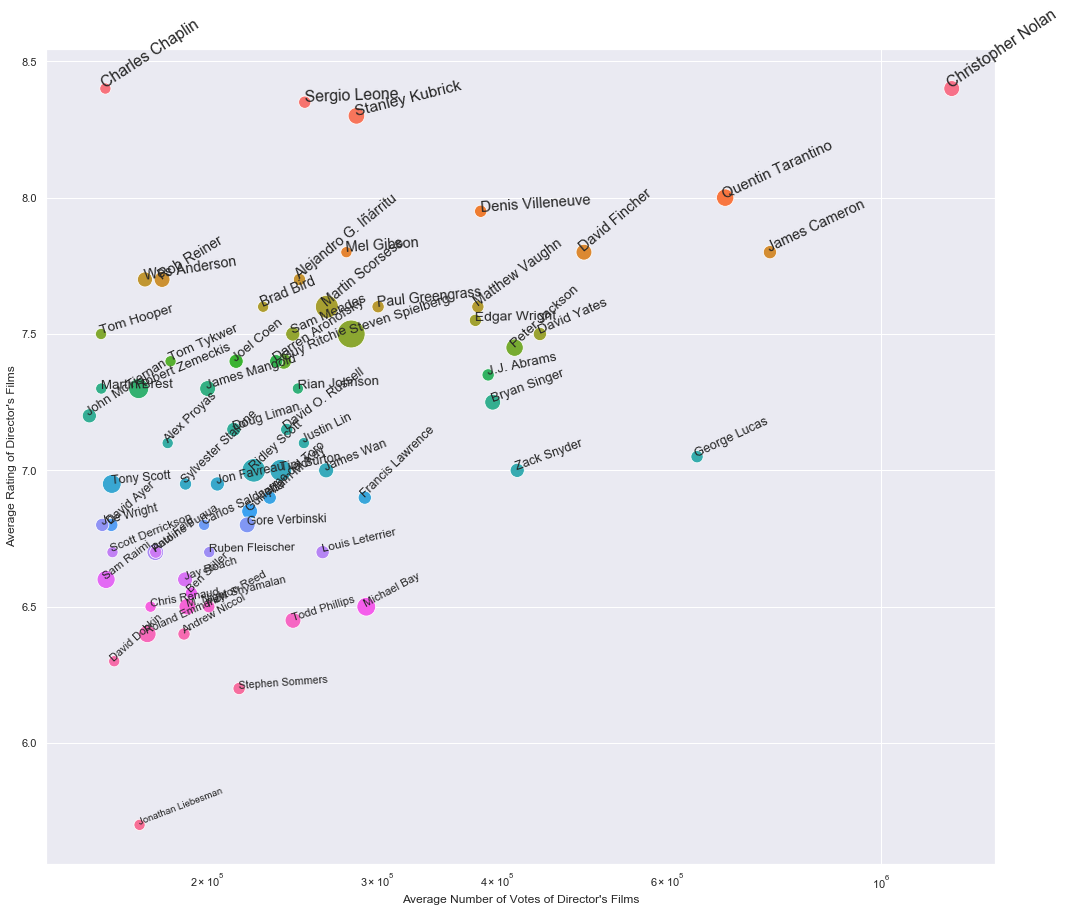

In [43]:
directors_successful = director_success[(director_success[("numVotes","median")]>150000)&\
                (director_success[("nconst","size")]>4)].sort_values(("averageRating","median"),ascending=False)

plt.figure(figsize=(17,15))
sns.scatterplot(y=directors_successful[("averageRating","median")],x=directors_successful[("numVotes","median")],
               s=directors_successful[("nconst","size")]*25,hue=directors_successful.index, legend=False,
               )
plt.xlabel("Average Number of Votes of Director's Films")
plt.ylabel("Average Rating of Director's Films")
plt.gca().set_xscale("log")

for names in directors_successful.T:
    plt.text(directors_successful.T[names][("numVotes","median")],
            directors_successful.T[names][("averageRating","median")],
             names,rotation=np.random.randint(0,45), rotation_mode="anchor",
             fontsize=directors_successful.T[names][("averageRating","median")]**1.3)

How about writers? Let's do the same analysis for them:
* Now Jonathan Nolan, younger brother of Christopher Nolan takes the lead as he is the co-writer for many of his brother's films
* Christopher Markus wrote many recent superhero movies, which is why he finds his spot more on the popular side (right)
* Andrew Stanton also wrote many successful animation series like Finding Nemo, Wall-E, Toy Story series

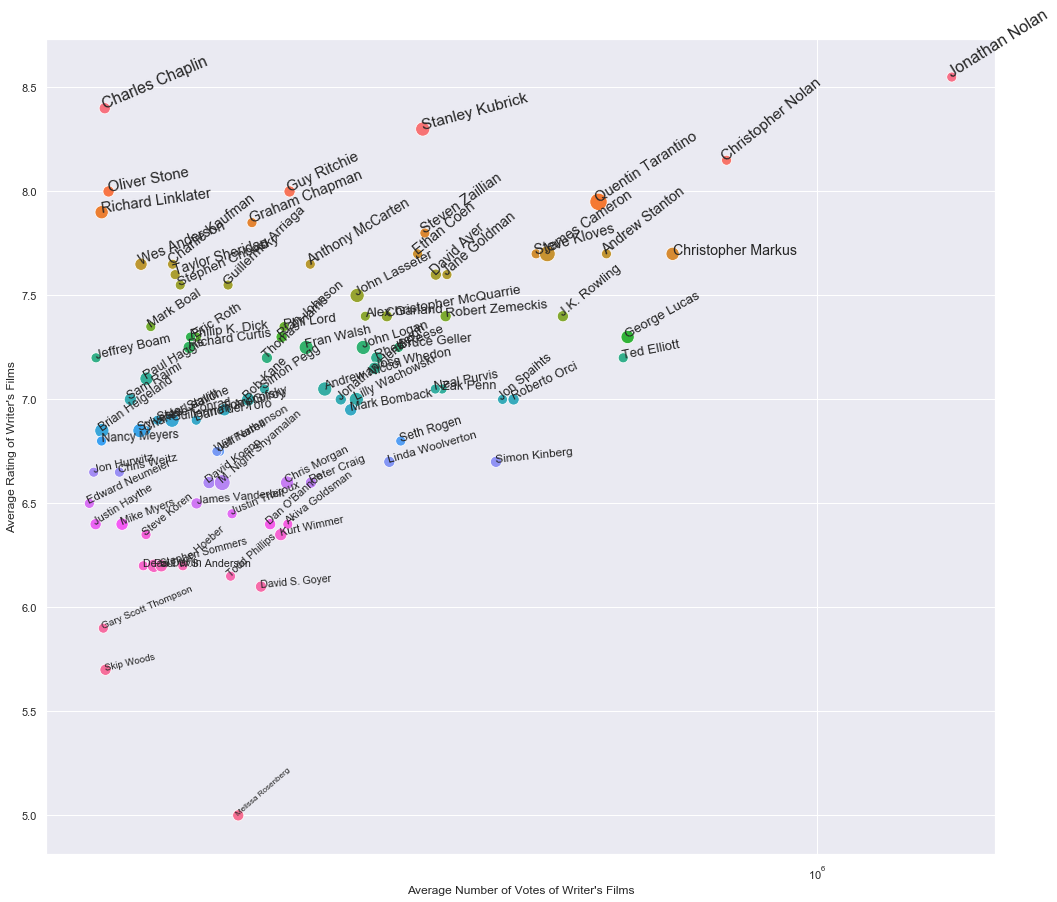

In [44]:
writer_temp = df_title_crew.drop("directors",axis=1)
writer_temp.columns = ["tconst","nconst"]
writer_temp.nconst = writer_temp.nconst.dropna().apply(lambda x: x.split(",")[0])

writers = pd.merge(pd.merge(pd.merge(df_title_basics,df_ratings,on="tconst"),
                          writer_temp,on="tconst"),
                 df_name_basics[["nconst","primaryName"]],on="nconst")

writer_success = writers[writers.numVotes>25000].groupby("primaryName").\
agg({"averageRating":[np.median],"numVotes":[np.median],"nconst":[np.size]}).\
sort_values(("averageRating","median"),ascending=False)

writers_successful = writer_success[(writer_success[("numVotes","median")]>150000)&\
                (writer_success[("nconst","size")]>=4)].sort_values(("averageRating","median"),ascending=False)

plt.figure(figsize=(17,15))
sns.scatterplot(y=writers_successful[("averageRating","median")],x=writers_successful[("numVotes","median")],
               s=writers_successful[("nconst","size")]*25,hue=writers_successful.index, legend=False,
               )
plt.xlabel("Average Number of Votes of Writer's Films")
plt.ylabel("Average Rating of Writer's Films")
plt.gca().set_xscale("log")

for names in writers_successful.T:
    plt.text(writers_successful.T[names][("numVotes","median")],
            writers_successful.T[names][("averageRating","median")],
             names,rotation=np.random.randint(0,45), rotation_mode="anchor",
             fontsize=writers_successful.T[names][("averageRating","median")]**1.3)

del writer_temp

### Title Principals Table

title.principals.tsv.gz – Contains the principal cast/crew for titles
* **tconst** (string) - alphanumeric unique identifier of the title
* **ordering** (integer) – a number to uniquely identify rows for a given titleId
* **nconst** (string) - alphanumeric unique identifier of the name/person
* **category** (string) - the category of job that person was in
* **job (string)** - the specific job title if applicable, else '\N'
* **characters** (string) - the name of the character played if applicable, else '\N'

In [48]:
df_title_principals = pickle.load(open("title.principals.sav","rb"))
df_title_principals.head(10)

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,NaN,"[""Self""]"
1,tt0000001,2,nm0005690,director,NaN,NaN
2,tt0000001,3,nm0374658,cinematographer,director of photography,NaN
3,tt0000002,1,nm0721526,director,NaN,NaN
4,tt0000002,2,nm1335271,composer,NaN,NaN
5,tt0000003,1,nm0721526,director,NaN,NaN
6,tt0000003,2,nm5442194,producer,producer,NaN
7,tt0000003,3,nm1335271,composer,NaN,NaN
8,tt0000003,4,nm5442200,editor,NaN,NaN
9,tt0000004,1,nm0721526,director,NaN,NaN


It is the largest table amongst other IMDb table with a size of almost 2GB. It contains over **38 million** principal cast/crew members such as actors/actresses, writer, director, producer, editor etc. which are associated to each film.

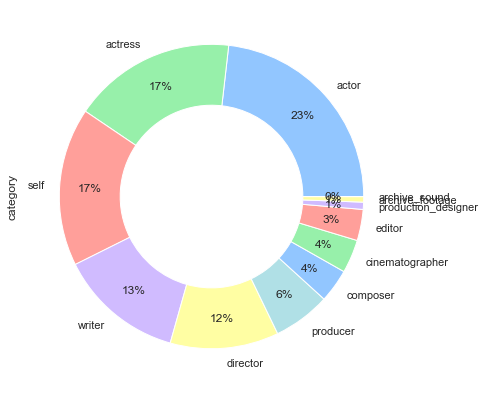

In [49]:
df_title_principals.category.value_counts().plot.pie(autopct="%.0f%%", pctdistance=0.8, figsize=(7,7),
                                                          wedgeprops=dict(width=0.4))

In [50]:
df_title_principals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38588696 entries, 0 to 38588695
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   tconst      object
 1   ordering    int64 
 2   nconst      object
 3   category    object
 4   job         object
 5   characters  object
dtypes: int64(1), object(5)
memory usage: 1.7+ GB


Let's find out who has been the most busy in film industry:
* Ilaiyaraaja and **William Shakespeare** are the contributors with the highest numbers
* Brahmanandam was involved more than a thousand films as an actor
* Other than Shakespeare not much known personalities there

In [51]:
inxs = df_title_principals.tconst.isin(df_title_basics.tconst)
use = df_title_principals[inxs]

top_names = use.nconst.value_counts().head(20)
top_names = pd.DataFrame(list(zip(top_names.index,top_names.values)),columns=["nconst","count"])
top_names = pd.merge(top_names,df_name_basics[["nconst","primaryName"]],on="nconst")

top_names["job_type"] = [use[use["nconst"] == i].category.value_counts().index[0] for i in top_names.nconst]
top_names

,nconst,count,primaryName,job_type
0,nm0006137,984,Ilaiyaraaja,composer
1,nm0000636,982,William Shakespeare,writer
2,nm0756966,939,Shôji Sakai,editor
3,nm0103977,808,Brahmanandam,actor
4,nm0006982,584,Adoor Bhasi,actor
5,nm0648803,564,Matsunosuke Onoe,actor
6,nm0305182,542,Eddie Garcia,actor
7,nm0232490,513,Dong-Chun Hyeon,editor
8,nm0453459,512,Hui-su Kim,editor
9,nm1930572,474,Kevin MacLeod,composer


### Title Akas Table

title.akas.tsv.gz - Contains the following information for titles:

* **titleId** (string) - a tconst, an alphanumeric unique identifier of the title
* **ordering** (integer) – a number to uniquely identify rows for a given titleId
* **title** (string) – the localized title
* **region** (string) - the region for this version of the title
* **language** (string) - the language of the title
* **types** (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning
* **attributes** (array) - Additional terms to describe this alternative title, not enumerated
* **isOriginalTitle** (boolean) – 0: not original title; 1: original title

In [52]:
df_title_akas = pickle.load(open("title.akas.sav","rb"))
df_title_akas.columns = ['tconst', 'ordering', 'title', 'region', 'language', 'types',
       'attributes', 'isOriginalTitle']
df_title_akas.head()

,tconst,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Carmencita,DE,NaN,NaN,literal title,0.0
1,tt0000001,2,Carmencita - spanyol tánc,HU,NaN,imdbDisplay,NaN,0.0
2,tt0000001,3,Καρμενσίτα,GR,NaN,imdbDisplay,NaN,0.0
3,tt0000001,4,Карменсита,RU,NaN,imdbDisplay,NaN,0.0
4,tt0000001,5,Carmencita,US,NaN,NaN,NaN,0.0


The table consist of the title's also known as (AKA) information such as the variations of title in different countries. There are **21 million** rows in the table. 

In [53]:
df_title_akas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21116454 entries, 0 to 21116453
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   tconst           object 
 1   ordering         int64  
 2   title            object 
 3   region           object 
 4   language         object 
 5   types            object 
 6   attributes       object 
 7   isOriginalTitle  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 1.3+ GB


We are only interested in movies, therefore akas table is inner joined with the **title basics** table

In [54]:
df_title_akas = pd.merge(df_title_akas,df_title_basics,on="tconst")
df_title_akas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971524 entries, 0 to 1971523
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   tconst           object 
 1   ordering         int64  
 2   title            object 
 3   region           object 
 4   language         object 
 5   types            object 
 6   attributes       object 
 7   isOriginalTitle  float64
 8   titleType        object 
 9   primaryTitle     object 
 10  originalTitle    object 
 11  startYear        float64
 12  runtimeMinutes   object 
 13  genres           object 
dtypes: float64(2), int64(1), object(11)
memory usage: 225.6+ MB


Let's now convert region codes into country names first. Then count them and visualise the Top 20:
* The count does not give total number of cinemas or tickets, it gives how many different number of films showed in cinemas in the country (the higher the number the more various films shown)
* US clearly the wins the competition
* Greece and Hungary finds themselves in the middle of the table, better than I would expect, interesting

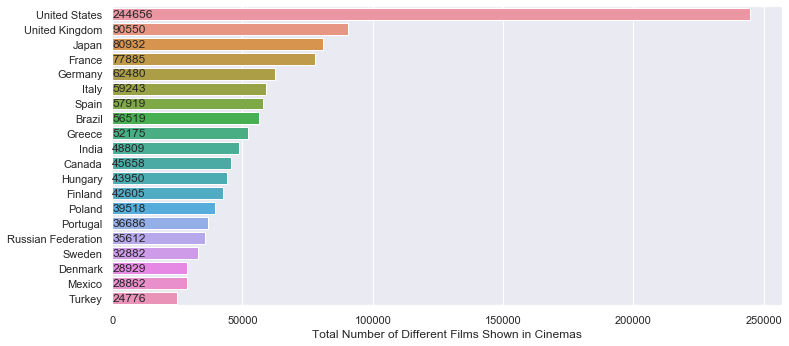

In [55]:
import pycountry
country_counts = df_title_akas.region.value_counts()
country_names = [pycountry.countries.get(alpha_2=coun).name for coun in country_counts.drop(["XWW","XWG"]).index[:20]]
counts = country_counts.drop(["XWW","XWG"]).values[:20]

plt.figure(figsize=(12,5.5))
sns.barplot(x=counts,y=country_names,orient="h")
plt.xlabel("Total Number of Different Films Shown in Cinemas")

for i,count in enumerate(counts):
    plt.text(100,i,count,va="center")

### Combine All Tables (for Movies only)

Now let's combine all tables by selecting only movie titles. In this way, we will reduce the dataset size and save it for future uses. It will be much faster to load and play with the final table:

In [64]:
df_movies = pd.merge(pd.merge(pd.merge(pd.merge(df_title_basics,df_ratings,on="tconst"),
                          df_title_crew,on="tconst"),
                     df_title_principals,on="tconst"),
                 df_name_basics,on="nconst")
df_movies.head()

,tconst,titleType,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,...,ordering,nconst,category,job,characters,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,tt0000009,movie,Miss Jerry,Miss Jerry,1894.0,45,Romance,5.3,88,nm0085156,...,1,nm0063086,actress,NaN,"[""Miss Geraldine Holbrook (Miss Jerry)""]",Blanche Bayliss,1878.0,1951.0,actress,tt0000009
1,tt0000009,movie,Miss Jerry,Miss Jerry,1894.0,45,Romance,5.3,88,nm0085156,...,2,nm0183823,actor,NaN,"[""Mr. Hamilton""]",William Courtenay,1875.0,1933.0,actor,"tt0000009,tt0020355,tt0021535,tt0020403"
2,tt0019859,movie,Evidence,Evidence,1929.0,NaN,NaN,7.1,14,nm0012317,...,3,nm0183823,actor,NaN,"[""Cyril Wimborne""]",William Courtenay,1875.0,1933.0,actor,"tt0000009,tt0020355,tt0021535,tt0020403"
3,tt0020403,movie,Show of Shows,Show of Shows,1929.0,128,NaN,5.9,328,nm0012317,...,2,nm0183823,actor,NaN,"[""The Minister - Guillotine Sequence""]",William Courtenay,1875.0,1933.0,actor,"tt0000009,tt0020355,tt0021535,tt0020403"
4,tt0000009,movie,Miss Jerry,Miss Jerry,1894.0,45,Romance,5.3,88,nm0085156,...,3,nm1309758,actor,NaN,"[""Chauncey Depew - the Director of the New Yor...",Chauncey Depew,1834.0,1928.0,"actor,writer","tt4518664,tt0000009,tt0490842,tt1076833"


Create a file called "df_movies.csv" and save the final table in .csv format

In [65]:
df_movies.to_csv("df_movies.csv")

The final table have 2.5 million rows, 21 columns

In [66]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2549460 entries, 0 to 2549459
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   tconst             object 
 1   titleType          object 
 2   primaryTitle       object 
 3   originalTitle      object 
 4   startYear          float64
 5   runtimeMinutes     object 
 6   genres             object 
 7   averageRating      float64
 8   numVotes           int64  
 9   directors          object 
 10  writers            object 
 11  ordering           int64  
 12  nconst             object 
 13  category           object 
 14  job                object 
 15  characters         object 
 16  primaryName        object 
 17  birthYear          float64
 18  deathYear          float64
 19  primaryProfession  object 
 20  knownForTitles     object 
dtypes: float64(4), int64(2), object(15)
memory usage: 427.9+ MB


I uploaded the data file (560MB) on WeTransfer which can be downloaded from the link below (WeTransfer deletes the uploads in 7 days, you can download the data until 14/04/2020):

https://we.tl/t-cQJVvEjZgv

You can do all the analysis above with this data as well as implementing your own ideas.

Cheers!